# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
# Import essential libraries

import numpy as np
import os
import shutil
import zipfile
from PIL import Image
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Load and unzip the dataset
zip_path = r'C:\Users\4270\Documents\Upgrad\CNN_Waste Segration\data.zip'
extract_path = 'Extracted_'

# Remove the folder if it already exists
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Load the dataset.

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [12]:
# Create a function to load the raw images
def load_images_by_category(root_dir, crop_box=None, target_size=None):
    images = []
    labels = []

    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file in os.listdir(category_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(category_path, file)
                try:
                    img = Image.open(file_path).convert("RGB")

                    if crop_box:
                        img = img.crop(crop_box)
                    if target_size:
                        img = img.resize(target_size)

                    images.append(img)
                    labels.append(category)

                except Exception as e:
                    print(f"Could not load {file_path}: {e}")
    
    return images, labels


root_folder = 'Extracted_'  
crop_coords = (50, 50, 200, 200)  
resize_to = (128, 128)

images, labels = load_images_by_category(root_folder, crop_box=crop_coords, target_size=resize_to)

print(f"Loaded {len(images)} images across {len(set(labels))} categories.")


Loaded 7625 images across 7 categories.


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [13]:
# Get the images and their labels
def load_images_and_labels(dataset_path, target_size=(128, 128)):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)  
    
    for label in label_names:
        label_path = os.path.join(dataset_path, label)
        
        if os.path.isdir(label_path):  
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                if file_path.endswith(('.jpg', '.jpeg', '.png', '.bmp')): 
                    try:
                        # Open and preprocess the image
                        img = Image.open(file_path)
                        img = img.resize(target_size)  
                        img_array = np.array(img) / 255.0  
                        
                        images.append(img_array)
                        labels.append(label)  
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")
    
    return np.array(images), np.array(labels)


dataset_path = 'Extracted_'  
images, labels = load_images_and_labels(dataset_path)


print(f"Loaded {len(images)} images with shape {images.shape}")
print(f"Loaded {len(labels)} labels")


print("Labels of the first 5 images:", labels[:5])

Loaded 7625 images with shape (7625, 128, 128, 3)
Loaded 7625 labels
Labels of the first 5 images: ['Cardboard' 'Cardboard' 'Cardboard' 'Cardboard' 'Cardboard']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution


# Visualise Data Distribution
from collections import Counter


label_counts = Counter(labels)

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

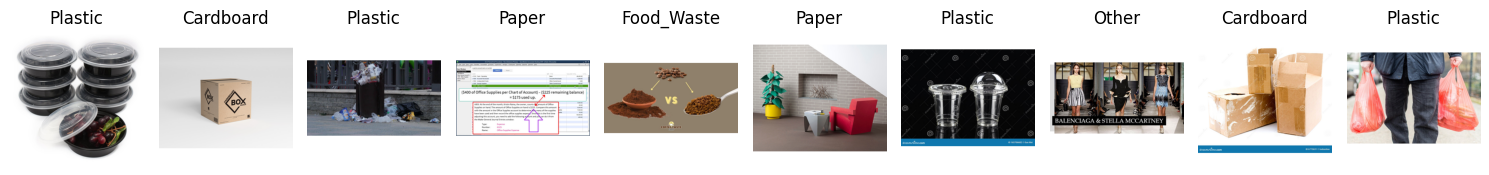

In [14]:
# Visualise Sample Images (across different labels)
def get_all_image_paths(dataset_path, valid_exts=('.jpg', '.jpeg', '.png', '.bmp')):
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(valid_exts):
                image_paths.append(os.path.join(root, file))
    return image_paths

def show_random_images_from_dataset(dataset_path, num_samples=10):
    # Get all image paths
    all_images = get_all_image_paths(dataset_path)
    
    # Randomly choose a few
    random_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Plot
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        label = os.path.basename(os.path.dirname(img_path))  # Folder name = label
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Use it with your dataset path
dataset_path = 'Extracted_'
show_random_images_from_dataset(dataset_path, num_samples=10)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [15]:
# Find the smallest and largest image dimensions from the data set


def find_image_dimension_extremes(dataset_path, valid_exts=('.jpg', '.jpeg', '.png', '.bmp')):
    widths = []
    heights = []
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(valid_exts):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                except Exception as e:
                    print(f"Error reading image {file}: {e}")
    
    min_width, max_width = min(widths), max(widths)
    min_height, max_height = min(heights), max(heights)
    
    print(f"Smallest dimensions: ({min_width}, {min_height})")
    print(f"Largest dimensions: ({max_width}, {max_height})")
    
    return (min_width, min_height), (max_width, max_height)

# Call the function
dataset_path = 'Extracted_'
min_dim, max_dim = find_image_dimension_extremes(dataset_path)

Smallest dimensions: (256, 256)
Largest dimensions: (256, 256)


In [16]:
# Resize the image dimensions
def resize_images_to_target(dataset_path, target_size=(128, 128), valid_exts=('.jpg', '.jpeg', '.png', '.bmp')):
    resized_images = []
    labels = []

    for root, _, files in os.walk(dataset_path):
        label = os.path.basename(root)
        for file in files:
            if file.lower().endswith(valid_exts):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)
                    img_array = np.array(img) / 255.0  # Normalize
                    resized_images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error resizing image {file}: {e}")
    
    return np.array(resized_images), np.array(labels)

# Resize to the smallest dimensions found
images_resized, labels_resized = resize_images_to_target(dataset_path, target_size=min_dim)
print(f"Resized {len(images_resized)} images to {min_dim}")

Resized 7625 images to (256, 256)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [17]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Display class-to-integer mapping
class_names = label_encoder.classes_
print("Classes found:", class_names)
print("First 5 encoded labels:", encoded_labels[:5])

Classes found: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
First 5 encoded labels: [0 0 0 0 0]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
 
img_size = (128, 128)
 
# Dataset root directory (with class folders)
dataset_path = "Extracted_"  # ← Replace this with your actual path
 
# Step 1: Collect all image paths and labels from subfolders
image_paths = []
labels = []
 
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # Folder name is the label
 
# Step 2: Split into Train, Validation, and Test
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
 
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
 
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
 
# Step 3: Load and resize images
def load_images(paths, target_size):
    data = []
    for path in paths:
        try:
            img = Image.open(path).convert("RGB").resize(target_size)
            data.append(np.array(img))
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return np.array(data, dtype='float32') / 255.0  # Normalize pixel values
 
X_train_arr = load_images(X_train, img_size)
X_val_arr = load_images(X_val, img_size)
X_test_arr = load_images(X_test, img_size)
 
# Step 4: Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)
 
# Step 5: One-hot encode
y_train_cat = to_categorical(y_train_enc)
y_val_cat = to_categorical(y_val_enc)
y_test_cat = to_categorical(y_test_enc)
 
# Final shape check
print(f"X_train shape: {X_train_arr.shape}, y_train shape: {y_train_cat.shape}")
print(f"X_val shape: {X_val_arr.shape}, y_val shape: {y_val_cat.shape}")
print(f"X_test shape: {X_test_arr.shape}, y_test shape: {y_test_cat.shape}")

Training set size: 4880
Validation set size: 1220
Test set size: 1525
X_train shape: (4880, 128, 128, 3), y_train shape: (4880, 7)
X_val shape: (1220, 128, 128, 3), y_val shape: (1220, 7)
X_test shape: (1525, 128, 128, 3), y_test shape: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [19]:
def create_model(input_shape, num_classes, dropout_rate=0.4):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),  # Smaller LR often helps with convergence
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
input_shape = (128, 128, 3)
num_classes = 7  # based on your labels
model = create_model(input_shape, num_classes)
model.summary()

C:\Users\4270\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,484,807 (32.37 MB)

 Trainable params: 8,484,359 (32.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [20]:
# Training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Train the model
history = model.fit(
    X_train_arr, y_train_cat,
    validation_data=(X_val_arr, y_val_cat),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 92s 546ms/step - accuracy: 0.2779 - loss: 3.3705 - val_accuracy: 0.1623 - val_loss: 5.4231
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.3233 - loss: 1.7383 - val_accuracy: 0.2852 - val_loss: 2.8180
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 549ms/step - accuracy: 0.3565 - loss: 1.6824 - val_accuracy: 0.3730 - val_loss: 1.6778
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 87s 568ms/step - accuracy: 0.3662 - loss: 1.6146 - val_accuracy: 0.3795 - val_loss: 1.6348
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 95s 619ms/step - accuracy: 0.4009 - loss: 1.4995 - val_accuracy: 0.4238 - val_loss: 1.5014
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 110s 719ms/step - accuracy: 0.4302 - loss: 1.4434 - val_accuracy: 0.4607 - val_loss: 1.5416
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 104s 682ms/step - accuracy: 0.4332 - loss: 1.4003 - val_accuracy: 0.4410 - val_loss: 1.4602
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 102s 666ms/step - accuracy: 0.4728 - loss

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Test Accuracy: 0.6249
Test Loss: 1.8319
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       108
           1       0.65      0.64      0.64       200
           2       0.55      0.60      0.58       150
           3       0.64      0.61      0.62       200
           4       0.60      0.44      0.50       202
           5       0.66      0.46      0.54       206
           6       0.62      0.75      0.68       459

    accuracy                           0.62      1525
   macro avg       0.63      0.62      0.61      1525
weighted avg       0.63      0.62      0.62      1525



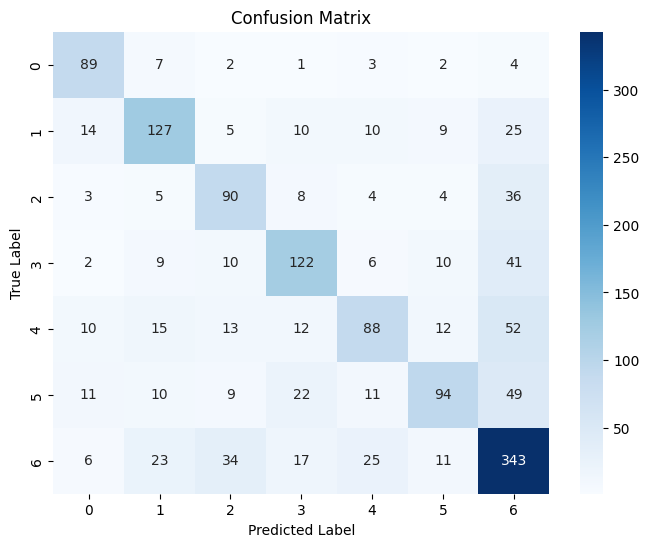

In [26]:
# Evaluate on the test set; display suitable metrics

# Evaluate test loss and accuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
test_loss, test_accuracy = model.evaluate(X_test_arr, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(X_test_arr)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

Test Accuracy: 62.49%

Test Loss1 831957

The classification report showed:

Precision rang5: 0668–0.86

Recall ra4ge:82.41–0.79

Strong performance on frequent classes (especially class 6)

Weaker performance on classes with fewer samples or similar visual features